## Introduction

Comparison between FIE kernel estimate, coupled bootstrap, and Sophie and Tian's estimator in the multi-observation setting. In the multi-observation setting, they use the mean $n-1$ observations.

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

import importlib
import sys
sys.path.append("../")
import methods  
importlib.reload(methods)

<module 'methods' from '/Users/timothysudijono/Projects/statistics/empirical_bayes/CompoundWelfareMaximization/analyses/../methods.py'>

## Test on the Netflix Data

In [104]:

df = pd.read_csv("data/example_te_data.csv").iloc[:,1:]
df["tstats"] = df["treatment_effects"]/df["standard_errors"]
df.head(10)
print(df.shape)

(331, 3)


In [105]:
np.random.seed(17)
true_effects = df.treatment_effects
synth_df = df.copy()
n = synth_df.shape[0]

In [106]:
J = 2
sigmas = np.array(df["standard_errors"])
Xs = np.array(synth_df.treatment_effects)[:,None] + np.random.normal(0,sigmas[:,None],size = (n,J))

In [107]:
def STE(Xs, sigmas, lb = -5, ub = 5, true_effects = None):
    """
    Sophie and Tian's Estimator
    """
    J = Xs.shape[1]
    if J < 2:
        raise ValueError("Num observations has to be greater than 1 per decision problem")
    
    C_grid = np.linspace(lb, ub, 500)

    J = Xs.shape[1]
    avgs = Xs.mean(axis = 1)
    loo_avgs = Xs[:,1:].mean(axis = 1)

    STE_welfare_curve = np.zeros_like(C_grid).astype(float)
    F1_curve = np.zeros_like(C_grid).astype(float)
    F2_curve = np.zeros_like(C_grid).astype(float)

    for i in range(len(C_grid)):
        c = C_grid[i]
        F1 = avgs*(loo_avgs >= c*sigmas/np.sqrt(J-1))
        F2 = (np.sqrt(J-1)/np.sqrt(J))*sigmas*norm.pdf((avgs - c*sigmas/np.sqrt(J-1))/(sigmas/np.sqrt(J*(J-1))))
        STE_welfare_curve[i] = F1.sum() - F2.sum()
        F1_curve[i] = F1.sum()
        F2_curve[i] = F2.sum()

    return STE_welfare_curve, F1_curve, F2_curve

def STE_RB(Xs, sigmas, lb = -5, ub = 5, true_effects = None):
    """
    eps: tuning parameter for the coupled bootstrap risk
    """
    J = Xs.shape[1]
    if J < 2:
        raise ValueError("Num observations has to be greater than 1 per decision problem")
    
    C_grid = np.linspace(lb, ub, 500)

    J = Xs.shape[1]
    avgs = Xs.mean(axis = 1)

    STE_RB_welfare_curve = np.zeros_like(C_grid).astype(float)
    F1_curve = np.zeros_like(C_grid).astype(float)
    F2_curve = np.zeros_like(C_grid).astype(float)

    for i in range(len(C_grid)):
        c = C_grid[i]
        input = (avgs - c*sigmas/np.sqrt(J-1))/(sigmas/np.sqrt(J*(J-1)))
        F1 = avgs*norm.cdf(input)
        F2 = (np.sqrt(J-1)/np.sqrt(J))*sigmas*norm.pdf(input)
        STE_RB_welfare_curve[i] = F1.sum() - F2.sum()
        F1_curve[i] = F1.sum()
        F2_curve[i] = F2.sum()

    return STE_RB_welfare_curve, F1_curve, F2_curve

NUWE Optimal Threshold: 0.11022044088176308
True Optimal Threshold: 0.030060120240480437
Optimal Threshold: 0.33066132264529013
True Optimal Threshold: 0.030060120240480437
Optimal Threshold: -0.010020040080160442


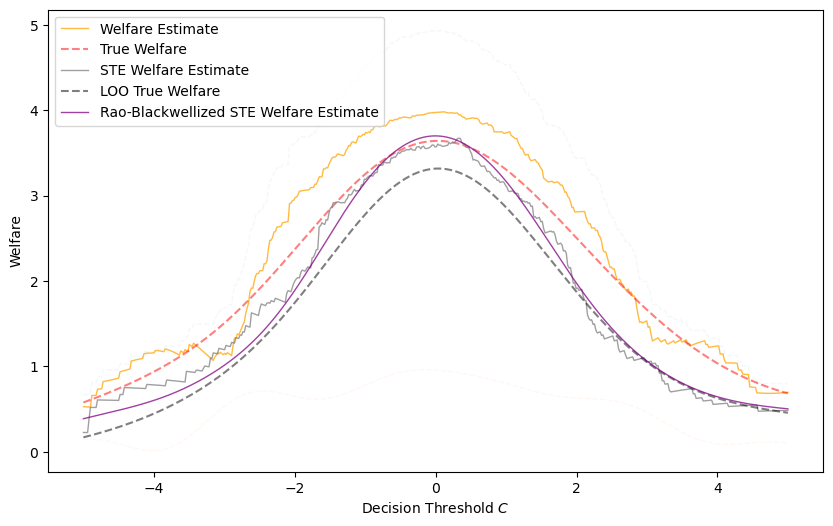

In [108]:
importlib.reload(methods)

### Applying NUWE
avgs = Xs.mean(axis = 1)
nuwe_welfare = methods.heteroskedastic_normal_welfare_estimator(avgs, sigmas/np.sqrt(J), true_effects = true_effects, plot = True)


### Applying STE
STE_welfare_curve, F_1, F_2 = STE(Xs, sigmas, true_effects = true_effects)
C_grid = np.linspace(-5, 5, 500)


plt.plot(C_grid, STE_welfare_curve, label = "STE Welfare Estimate", linewidth = 1, alpha = 0.75, color = "gray")
plt.xlabel("Decision Threshold $C$")
plt.ylabel("Welfare")
print("Optimal Threshold:", C_grid[np.argmax(STE_welfare_curve)])

LOO_true_risk = np.zeros_like(C_grid)
for i in range(len(C_grid)):
    LOO_true_risk[i] = np.sum(true_effects*norm.cdf(np.sqrt(J-1)*true_effects/sigmas - C_grid[i]))

print("True Optimal Threshold:", C_grid[np.argmax(LOO_true_risk)])
plt.plot(C_grid, LOO_true_risk, color = "black", linestyle = "dashed", alpha = 0.5, label = "LOO True Welfare")

### Applying STE_RB
STE_RB_welfare_curve, F_1, F_2 = STE_RB(Xs, sigmas, true_effects = true_effects)

plt.plot(C_grid, STE_RB_welfare_curve, label = "Rao-Blackwellized STE Welfare Estimate", linewidth = 1, alpha = 0.75, color = "purple")
plt.xlabel("Decision Threshold $C$")
plt.ylabel("Welfare")
print("Optimal Threshold:", C_grid[np.argmax(STE_RB_welfare_curve)])

plt.legend()
plt.savefig("results/comparison_multiple_observations.pdf", bbox_inches = 'tight')

## In-sample Welfare Gain

Now we calculate in-sample welfare (the sum of mus I get from making the decision).

In [117]:
true_effects = df.treatment_effects
sigmas = np.array(df["standard_errors"])
J = 2

C_grid = np.linspace(-5, 5, 500)

mc_runs = 50
nuwe_welfares = np.zeros(mc_runs).astype(float)
ste_welfares = np.zeros(mc_runs).astype(float)
ste_rb_welfares = np.zeros(mc_runs).astype(float)

for j in range(mc_runs):

    Xs = np.array(synth_df.treatment_effects)[:,None] + np.random.normal(0,sigmas[:,None],size = (n,J))

    avgs = Xs.mean(axis = 1)
    loo_avgs = Xs[:,1:].mean(axis = 1)

    ### NUWE
    nuwe_curve = methods.heteroskedastic_normal_welfare_estimator(avgs, sigmas/np.sqrt(J));
    threshold = C_grid[np.argmax(nuwe_curve)]
    nuwe_welfares[j] = true_effects[avgs >= threshold*sigmas/np.sqrt(J)].sum()

    ### STE
    STE_welfare_curve, F_1, F_2 = STE(Xs, sigmas, true_effects = true_effects)
    threshold = C_grid[np.argmax(STE_welfare_curve)]
    ste_welfares[j] = true_effects[loo_avgs >= threshold*sigmas/np.sqrt(J-1)].sum()

    ### STE Rao Blackwell
    STE_RB_welfare_curve, F_1, F_2 = STE_RB(Xs, sigmas, true_effects = true_effects)
    threshold = C_grid[np.argmax(STE_RB_welfare_curve)]
    ste_rb_welfares[j] = true_effects[loo_avgs >= threshold*sigmas/np.sqrt(J-1)].sum()


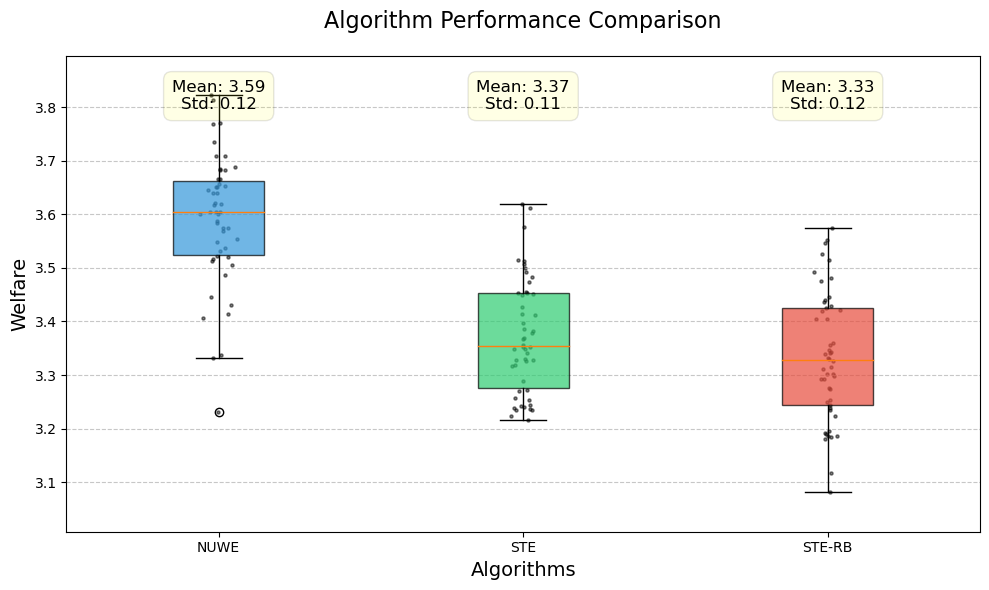

In [118]:
def compare_insample_welfares(nuwe_welfares, ste_welfares, ste_rb_welfares, title):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create boxplots
    box_data = [nuwe_welfares, ste_welfares, ste_rb_welfares]
    labels = ['NUWE', 'STE', 'STE-RB']

    # Box plot with customization
    boxplot = ax.boxplot(box_data, patch_artist=True, labels=labels)

    # Customize the boxplots
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    for box, color in zip(boxplot['boxes'], colors):
        box.set(facecolor=color, alpha=0.7)
        
    # Add a horizontal grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add labels and title
    ax.set_title('Algorithm Performance Comparison', fontsize=16, pad=20)
    ax.set_ylabel('Welfare', fontsize=14)
    ax.set_xlabel('Algorithms', fontsize=14)

    # Add some padding to y-axis for better visualization
    y_min = min([min(data) for data in box_data])
    y_max = max([max(data) for data in box_data])
    padding = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - padding, y_max + padding)

    # Optional: Add data points
    for i, data in enumerate(box_data):
        # Add a small horizontal jitter to better visualize the points
        x = np.random.normal(i+1, 0.02, size=len(data))
        ax.scatter(x, data, alpha=0.5, s=5, color='black')

    # Add some statistics in the plot
    for i, data in enumerate(box_data):
        stats_text = f"Mean: {np.mean(data):.2f}\nStd: {np.std(data):.2f}"
        ax.annotate(stats_text, xy=(i+1, y_max), xytext=(0, -10),
                    textcoords='offset points', ha='center', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.1))

    plt.tight_layout()
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

compare_insample_welfares(nuwe_welfares, ste_welfares,ste_rb_welfares, title="results/paired_scatter_comparison.pdf")

## OA Example

In [119]:
def load_data_for_outcome(est_var):
    """
    Load the processed data for a given outcome variable
    Filter out missing values and values where the standard error is too large
    """
    df = pd.read_feather("data/oa_data_used.feather")
    se_var = est_var + "_se"
    subset = df[[est_var, se_var, "czname", "state", "county", "tract"]].dropna()
    thresh = subset[se_var].quantile(0.995)
    subset = subset.loc[subset[se_var] <= thresh].reset_index(drop=True)

    return subset

est_var = "kfr_top20_black_pooled_p25"
df = load_data_for_outcome(est_var)
estimates = df[est_var].values
standard_errors = df[est_var + "_se"].values

n = len(estimates)
J = 2
true_effects = estimates

sigmas = standard_errors
Xs = np.array(estimates)[:,None] + np.random.normal(0,sigmas[:,None],size = (n,J))

NUWE Optimal Threshold: -0.6913827655310625
True Optimal Threshold: -0.811623246492986
STE Optimal Threshold: -1.0721442885771544
True LOO Optimal Threshold: -1.0921843687374753
Optimal Threshold: -1.1322645290581166


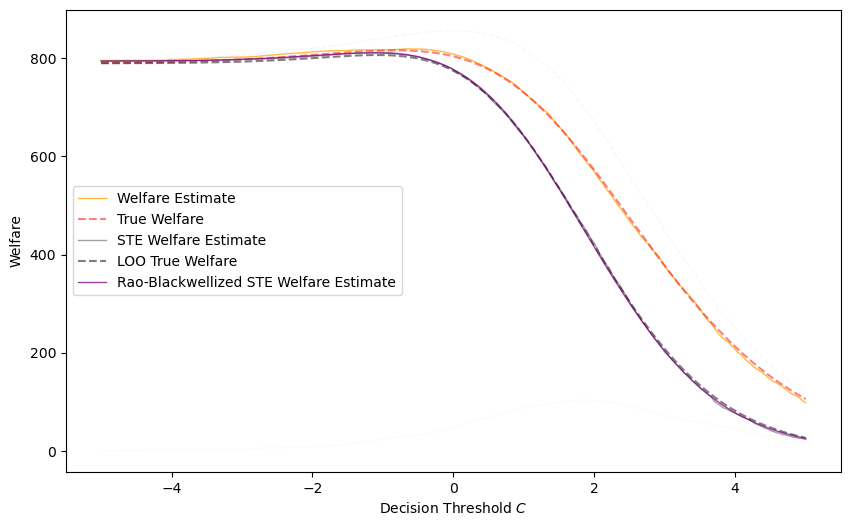

In [120]:
importlib.reload(methods)

### Applying NUWE
avgs = Xs.mean(axis = 1)
nuwe_welfare = methods.heteroskedastic_normal_welfare_estimator(avgs, sigmas/np.sqrt(J), true_effects = true_effects, plot = True)


### Applying STE
STE_welfare_curve, F_1, F_2 = STE(Xs, sigmas, true_effects = true_effects)
C_grid = np.linspace(-5, 5, 500)


plt.plot(C_grid, STE_welfare_curve, label = "STE Welfare Estimate", linewidth = 1, alpha = 0.75, color = "gray")
plt.xlabel("Decision Threshold $C$")
plt.ylabel("Welfare")
print("STE Optimal Threshold:", C_grid[np.argmax(STE_welfare_curve)])

LOO_true_risk = np.zeros_like(C_grid)
for i in range(len(C_grid)):
    LOO_true_risk[i] = np.sum(true_effects*norm.cdf(np.sqrt(J-1)*true_effects/sigmas - C_grid[i]))

print("True LOO Optimal Threshold:", C_grid[np.argmax(LOO_true_risk)])
plt.plot(C_grid, LOO_true_risk, color = "black", linestyle = "dashed", alpha = 0.5, label = "LOO True Welfare")

### Applying STE_RB
STE_RB_welfare_curve, F_1, F_2 = STE_RB(Xs, sigmas, true_effects = true_effects)

plt.plot(C_grid, STE_RB_welfare_curve, label = "Rao-Blackwellized STE Welfare Estimate", linewidth = 1, alpha = 0.75, color = "purple")
plt.xlabel("Decision Threshold $C$")
plt.ylabel("Welfare")
print("Optimal Threshold:", C_grid[np.argmax(STE_RB_welfare_curve)])

plt.legend()
plt.savefig("results/OA_comparison_multiple_observations.pdf", bbox_inches = 'tight')

In [128]:
true_effects = estimates
sigmas = standard_errors
J = 2
C_grid = np.linspace(-5, 5, 500)

mc_runs = 20
nuwe_welfares = np.zeros(mc_runs).astype(float)
ste_welfares = np.zeros(mc_runs).astype(float)
ste_rb_welfares = np.zeros(mc_runs).astype(float)

for j in range(mc_runs):

    Xs = np.array(estimates)[:,None] + np.random.normal(0,sigmas[:,None],size = (n,J))

    avgs = Xs.mean(axis = 1)
    loo_avgs = Xs[:,1:].mean(axis = 1)

    ### NUWE
    nuwe_curve = methods.heteroskedastic_normal_welfare_estimator(avgs, sigmas/np.sqrt(J));
    threshold = C_grid[np.argmax(nuwe_curve)]
    nuwe_welfares[j] = true_effects[avgs >= threshold*sigmas/np.sqrt(J)].sum()

    ### STE
    STE_welfare_curve, F_1, F_2 = STE(Xs, sigmas)
    threshold = C_grid[np.argmax(STE_welfare_curve)]
    ste_welfares[j] = true_effects[loo_avgs >= threshold*sigmas/np.sqrt(J-1)].sum()

    ### STE Rao Blackwell
    STE_RB_welfare_curve, F_1, F_2 = STE_RB(Xs, sigmas)
    threshold = C_grid[np.argmax(STE_RB_welfare_curve)]
    ste_rb_welfares[j] = true_effects[loo_avgs >= threshold*sigmas/np.sqrt(J-1)].sum()

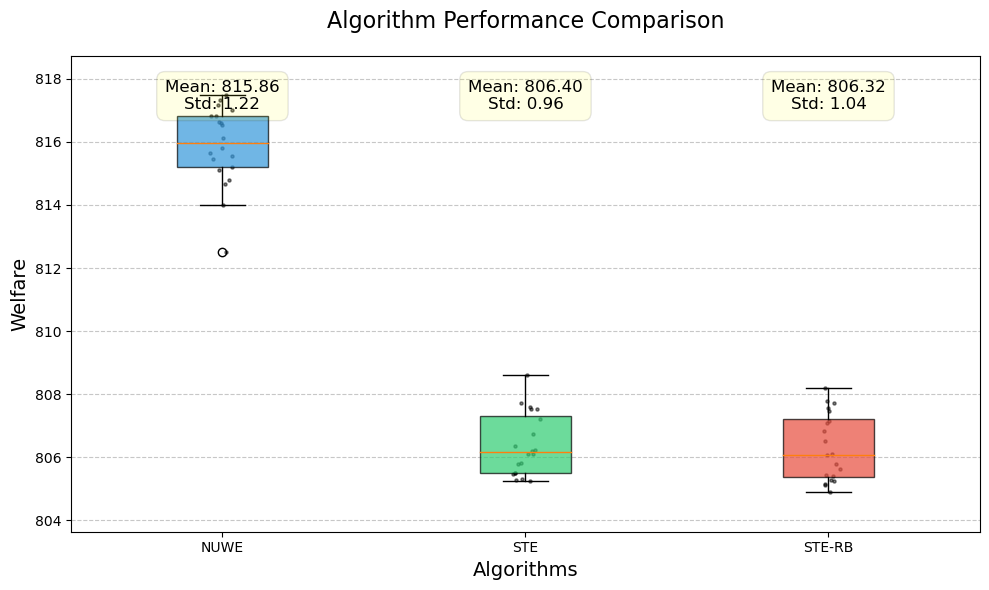

In [129]:
compare_insample_welfares(nuwe_welfares, ste_welfares, ste_rb_welfares, title="results/OA_paired_scatter_comparison.pdf")